In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import erfc

class OFDMSystem:
    def __init__(self, n_bits, Ts, sigmas=0, vtEbN0_dB=0):
        self.n_bits = n_bits
        self.Ts = Ts
        self.T = int(n_bits / Ts)
        self.K = int(self.T / Ts)
        self.N = 2 * self.K
        self.sigmas = sigmas
        self.vtEbN0_dB = vtEbN0_dB

    def generate_random_bits(self):
        data_in = np.random.rand(self.n_bits)
        return np.sign(data_in - 0.5).reshape((int(self.n_bits / 4), 4))

    def generate_16QAM_sequence(self, data_in_matrix):
        seq_16 = 2 * data_in_matrix[:, 0] + data_in_matrix[:, 1] + 1j * (2 * data_in_matrix[:, 2] + data_in_matrix[:, 3])
        return np.concatenate([seq_16, np.conj(seq_16[::-1])])

    def construct_xn(self, X):
        return np.fft.ifft(X, norm='ortho')

    def add_noise_variance(self, xn, variance):
        noise = np.sqrt(variance) * np.random.randn(self.N) + 1j * np.sqrt(variance) * np.random.randn(self.N)
        return xn + noise

    def add_noise_ebn0(self, xn, vtEbN0_dB):
        noise = 1 / np.sqrt(2) * (np.random.randn(int(self.N)) + 1j * np.random.randn(int(self.N)))
        noise *= 10 ** (-vtEbN0_dB / 20)
        return xn + noise

    @staticmethod
    def perform_demodulation(Y):
        Z = np.zeros(len(Y), dtype=complex)
        for k in range(len(Y)):
            if np.real(Y[k]) > 0:
                if np.real(Y[k]) > 2:
                    Z[k] = 3
                else:
                    Z[k] = 1
            else:
                if np.real(Y[k]) < -2:
                    Z[k] = -3
                else:
                    Z[k] = -1

            if np.imag(Y[k]) > 0:
                if np.imag(Y[k]) > 2:
                    Z[k] += 1j * 3
                else:
                    Z[k] += 1j
            else:
                if np.imag(Y[k]) < -2:
                    Z[k] -= 1j * 3
                else:
                    Z[k] -= 1j
        return Z

    @staticmethod
    def count_errors(Z, X):
        return len(np.where(Z - X != 0)[0])

    @staticmethod
    def plot_results_signal(Y, seq16, variance):
        plt.scatter(np.real(Y), np.imag(Y), label="Received Signal")
        plt.scatter(np.real(seq16), np.imag(seq16), label="16-QAM Constellation")
        plt.title('Signal with Noise Variance ' + str(variance))
        plt.legend()
        plt.show()

    @staticmethod
    def plot_results_ber(vtEbN0_dB, BER_sim, BER_theo):
        plt.figure(1, [14, 7])
        plt.semilogy(vtEbN0_dB, BER_sim, 'ro', label='Simulated AWGN')
        plt.semilogy(vtEbN0_dB, BER_theo, 'b--', label='Theoretical AWGN')
        plt.grid()
        plt.legend()
        plt.title("E_b/N_0 Vs BER for 16QAM")
        plt.xlabel('E_b/N_0(dB)')
        plt.ylabel('BER or Pe')
        plt.show()

def main_noise_variance():
    n_bits = 100
    Ts = 2
    sigmas = [0.01, 0.1, 1]

    ofdm_system = OFDMSystem(n_bits, Ts, sigmas=sigmas)
    data_in_matrix = ofdm_system.generate_random_bits()
    seq16 = ofdm_system.generate_16QAM_sequence(data_in_matrix)
    xn = ofdm_system.construct_xn(seq16)

    for variance in sigmas:
        rn = ofdm_system.add_noise_variance(xn, variance)
        Y = np.fft.fft(rn, norm='ortho')
        ofdm_system.plot_results_signal(Y, seq16, variance)
        Z = ofdm_system.perform_demodulation(Y)
        error_count = ofdm_system.count_errors(Z, seq16)
        print(f'For variance {variance}, there were {error_count} symbols decoded incorrectly.')

def main_ber():
    n_bits = int(1e6)
    Ts = 2
    vtEbN0_dB = np.arange(0, 15)

    ofdm_system = OFDMSystem(n_bits, Ts, vtEbN0_dB=vtEbN0_dB)
    data_in_matrix = ofdm_system.generate_random_bits()
    seq16 = ofdm_system.generate_16QAM_sequence(data_in_matrix)
    xn = ofdm_system.construct_xn(seq16)

    simulated_BER = []
    for ebn0 in vtEbN0_dB:
        rn = ofdm_system.add_noise_ebn0(xn, ebn0)
        Y = np.fft.fft(rn, norm='ortho')
        Z = ofdm_system.perform_demodulation(Y)
        error = ofdm_system.count_errors(Z, seq16)
        print(f'For EbN0 = {ebn0} dB, there are {error} symbols decoded incorrectly.')
        simulated_BER.append(error / (n_bits / 4))
    theoretical_BER = (3 / (2 * 4)) * erfc(np.sqrt((4 / 10) * 10**(ofdm_system.vtEbN0_dB / 10)))
    ofdm_system.plot_results_ber(vtEbN0_dB, simulated_BER, theoretical_BER)

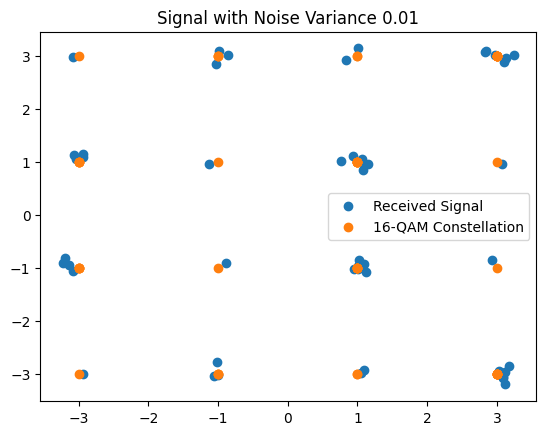

For variance 0.01, there were 0 symbols decoded incorrectly.


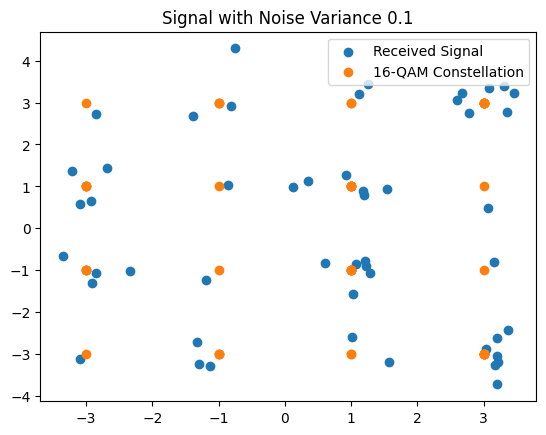

For variance 0.1, there were 0 symbols decoded incorrectly.


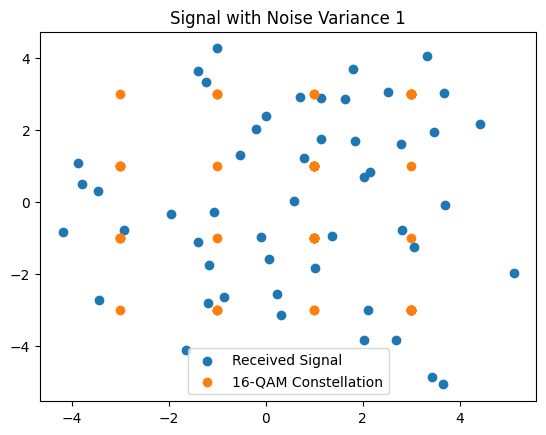

For variance 1, there were 22 symbols decoded incorrectly.


In [2]:
main_noise_variance()

For EbN0 = 0 dB, there are 110695 symbols decoded incorrectly.
For EbN0 = 1 dB, there are 81307 symbols decoded incorrectly.
For EbN0 = 2 dB, there are 54181 symbols decoded incorrectly.
For EbN0 = 3 dB, there are 33479 symbols decoded incorrectly.
For EbN0 = 4 dB, there are 18673 symbols decoded incorrectly.
For EbN0 = 5 dB, there are 8902 symbols decoded incorrectly.
For EbN0 = 6 dB, there are 3598 symbols decoded incorrectly.
For EbN0 = 7 dB, there are 1155 symbols decoded incorrectly.
For EbN0 = 8 dB, there are 293 symbols decoded incorrectly.
For EbN0 = 9 dB, there are 53 symbols decoded incorrectly.
For EbN0 = 10 dB, there are 9 symbols decoded incorrectly.
For EbN0 = 11 dB, there are 1 symbols decoded incorrectly.
For EbN0 = 12 dB, there are 0 symbols decoded incorrectly.
For EbN0 = 13 dB, there are 0 symbols decoded incorrectly.
For EbN0 = 14 dB, there are 0 symbols decoded incorrectly.


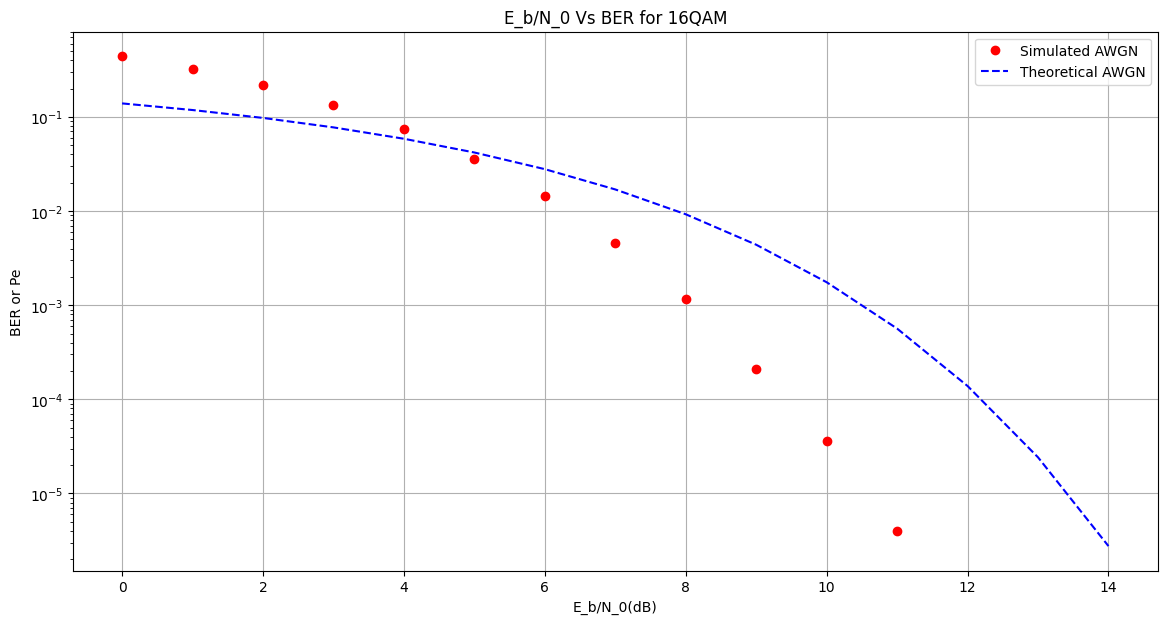

In [3]:
main_ber()